# Introduction

If we want to know whether a review has a positive or negative rating for a movie, we can count the number of likes and dislikes in the reviews to see which type appears more frequently.

In this project, I will perform naive Bayesian classification of the text of movie reviews and the ability to predict whether a movie review is positive or negative based on the review text. Also I want to check how Naive Bayes predicts which newsgroup a post is submitted to based on the text of the post.

The naive Bayes formula I will use is:
$$log\left(P\left(class\left|text\right|\right)\right)=log\left(P\left(text\left|class\right|\right)\cdot P\left(class\right)\right)\:$$

This formula can be converted to $$log\left(P\left(text\left|class\right|\right)\right)+log\left(P\left(class\right)\right)$$

### Training texts of "movie_reviews.zip"

In this part I'm going to check that the Naive Bayes classifier predicts whether a movie review is positive or negative, and check the accuracy of the classifier.

In [495]:
import pandas as pd
import re
import numpy as np
from zipfile import ZipFile
from collections import Counter
movies = pd.read_csv("movie_reviews.zip")

The file movie_reviews.zip is a zipped csv file containing texts of about 25,000 movie reviews. Each review is accompanied by a label, indicating if the review is positive or negative.

In [496]:
with open('stopwords.txt') as f:
    stops = f.read()
stops = stops.split(',')

These words that make up the grammatical structure are meaningless, but will generate a lot of noise. Removing these "noise" words will improve the classification accuracy. We call these words "stop words".

In [497]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(movies, test_size=0.8, random_state=1)

In [499]:
dfp = train_df[train_df["sentiment"] == 'positive']
dfn = train_df[train_df["sentiment"] == 'negative']

Get two DataFrames containing all rows containing "positive" and "negative" in column "sentiment"

In [500]:
ls = []
st = ""
for i in range(0,len(dfp)):
    s1 = dfp.iloc[i]['review'].lower()              # Convert all words in positive reviews to lowercase.
    s1 = re.sub(r"[\".,?;:)(-]|<br />",'',s1)       # Remove punctuation.
    st = st + " " + s1
ls = st.split()                                     # Separate words.
c1 = Counter(ls)                                    # Count the number of occurrences of each word in positive reviews.

In [501]:
ls1 = []
st1 = ""
for i in range(0,len(dfn)):
    s1 = dfn.iloc[i]['review'].lower()              
    s1 = re.sub(r"[\".,?;:)(-]|<br />",'',s1)    # Convert all words in negative reviews to lowercase.
    st1 = st1 + " " + s1
    
ls1 = st1.split()
c2 = Counter(ls1)                                # Count the number of occurrences of each word in negative reviews.

In [502]:
d = {'positive': c1, 'negative': c2}
df = pd.DataFrame(d)
df = df.fillna(0)
df = df.sort_values("positive", ascending=False)
df = df.drop(stops, errors='ignore')            # Remove "stop words".
df

,positive,negative
film,3865.0,3647.0
movie,3694.0,4659.0
one,2512.0,2452.0
very,1687.0,1135.0
out,1606.0,1719.0
...,...,...
cuteit,0.0,1.0
rushed8,0.0,1.0
destructs,0.0,1.0
gyaos,0.0,1.0


Convert the number of occurrences of each word in "positive reviews" and "negative reviews" into a DataFrame, and remove "stop words".

In [503]:
df['positive-probility'] = df['positive']/df.sum()['positive']
df['negative-probility'] = df['negative']/df.sum()['negative']

Calculate the probability of each word appearing in different categories, which is $$ P\left(class\left|text\right|\right)$$

In [588]:
df['log(P(pos|text))'] = np.log10(df['positive-probility']) + np.log10((df.sum()['positive']/S))
df['log(P(neg|text))'] = np.log10(df['negative-probility']) + np.log10((df.sum()['negative']/S))
df1 = df[df["positive"] > 1]
df1 = df1[df1["negative"] > 1]
# Remove words that appear less than 1 time, which can make the prediction result more accurate.
df1

,positive,negative,positive-probility,negative-probility,log(P(pos|text)),log(P(neg|text))
film,3865.0,3647.0,0.012388,0.012137,-2.470167,-2.495380
movie,3694.0,4659.0,0.011839,0.015505,-2.489819,-2.389023
one,2512.0,2452.0,0.008051,0.008160,-2.657296,-2.667796
very,1687.0,1135.0,0.005407,0.003777,-2.830201,-3.002320
out,1606.0,1719.0,0.005147,0.005721,-2.851571,-2.822040
...,...,...,...,...,...,...
prosecution,2.0,3.0,0.000006,0.000010,-5.756286,-5.580195
greenaway,2.0,3.0,0.000006,0.000010,-5.756286,-5.580195
canvas,2.0,2.0,0.000006,0.000007,-5.756286,-5.756286
smuggle,2.0,3.0,0.000006,0.000010,-5.756286,-5.580195


If we use products to compare probabilities, Python can't handle such small decimals, and they all end up being zero. So we're going to do it with logarithms, adding up the logarithms of each probability.

$$log\left(P\left(text\left|class\right|\right)\cdot P\left(class\right)\right)\:$$ can be converted to:

$$\:log\left(P\left(text\left|class\right|\right)\right)+log\left(P\left(class\right)\right)$$

### Test texts of "movie_reviews.zip"

In [589]:
def classify(txt):
    a = txt.lower()                                     # Convert all words in positive reviews to lowercase.
    a = re.sub(r"[\".,?;:)(-]|<br />",'',a)             # Remove punctuation.
    a = a.split()                                       # Separate words.
    c4 = Counter(a)                                     # Count the number of occurrences of each word in the test review.
    df3 = pd.DataFrame({'text':c4})
    inner_merge = pd.merge(df1, df3,                    # Overlap common words.
                       left_on=df1.index,
                       right_on=df3.index,
                       how="inner")
    return inner_merge

First, I wrote a function classify(txt) to find words that appear in both "df1" and "test text". I convert "test review" to lowercase and remove punctuation, get each word in "test review" and the number of times they appear through "Counter", and convert it to a DataFrame. Finally, use "pd.merge" to get the words they both have.

In [675]:
predict_list = []
def predict(x):
    if x['log(P(pos|text))'] > x['log(P(neg|text))']:
        predict_list.append("positive")
    else:
        predict_list.append("negative")

By function classify I can get the probability table of words.

Then, this function predict can collect the obtained prediction results to determine the classification with greater probability.

In [676]:
for i in range(0,len(test_df)):           # Make classification predictions for all reviews in test_df.
    txt = test_df.iloc[i]['review']
    result = classify(txt).sum()
    predict(result)

In [677]:
(predict_list == test_df['sentiment']).sum()/len(test_df)

0.8405

Now I can say that using the Naive Bayes classifier predicts whether a movie review is positive or negative with 84.05% accuracy.

## Training texts of "newsgroups.zip"

In this part I'm going to use how Naive Bayes predicts which newsgroup a post is submitted to based on the text of the post and check the accuracy of the classifier.

In [512]:
with ZipFile("newsgroups.zip") as zipped:
    txt0 = zipped.read('newsgroups.txt').decode(encoding='utf8', errors='ignore')

In [537]:
list_topics=[]
a = re.findall(r"Newsgroup: .*\S", txt0)       # Find all categories by "Newsgroup".
for item in a:
    list_topics.append(item.split(': ')[1])    # list of the different topics.



l2 = []
b = re.sub(r"From: .*\n",'', txt0)             # Remove the "From" part of the texts.
b = re.sub(r"Subject: .*\n\n\n",'', b)         # Remove the "Subject" part of the texts.
b = re.split(r"Newsgroup: .*\n", b)            # Segment reviews according to "Newsgroup".

list_review =[re.sub(r"[#*&|\".,?$;:!<>+%=/)(]|\n|-|\t|\d+", '', i) for i in b]      # Remove punctuation.
list_review.pop(0)                             # Remove the first empty element.

''

In [538]:
d_topics = {"topics":list_topics}
d_review = {"review":list_review}
df10 = pd.DataFrame(d_review)
df11 = pd.DataFrame(d_topics)

Get two DataFrames containing all rows containing "texts" and "topics" in "test_df".

In [604]:
newsgroups_df = pd.concat([df11, df10], axis=1)   # Concatenate two DataFrames

In [605]:
Newstrain_df, Newstest_df = train_test_split(newsgroups_df, test_size=0.8, random_state=1)

In [606]:
grouped = Newstrain_df.groupby("topics")
# Group rows the DataFrame into parts, depending on the value of the “topics” column.

In this part of the code below, I am trying to get the number of occurrences of words in each topics.First, I get the texts of each topic through "grouped.get_group", then convert all words in texts to lowercase, and finally use "Counter" to count the number of occurrences of each word.

In [708]:
ls_rec_autos = []
st_rec_autos = ""
for i in range(0,len(grouped.get_group("rec.autos"))):
    s1 = grouped.get_group("rec.autos").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_rec_autos = st_rec_autos + " " + s1
    
ls_rec_autos = st_rec_autos.split()
count_rec_autos = Counter(ls_rec_autos)


In [709]:
ls_sci_med = []
st_sci_med = ""
for i in range(0,len(grouped.get_group("sci.med"))):
    s1 = grouped.get_group("sci.med").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_sci_med = st_sci_med + " " + s1
    
ls_sci_med = st_sci_med.split()
count_sci_med = Counter(ls_sci_med)


In [710]:
ls_alt_atheism = []
st_alt_atheism = ""
for i in range(0,len(grouped.get_group("alt.atheism"))):
    s1 = grouped.get_group("alt.atheism").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_alt_atheism = st_alt_atheism + " " + s1
    
ls_alt_atheism = st_alt_atheism.split()
count_alt_atheism = Counter(ls_alt_atheism)

In [711]:
ls_rec_sport_baseball = []
st_rec_sport_baseball = ""
for i in range(0,len(grouped.get_group("rec.sport.baseball"))):
    s1 = grouped.get_group("rec.sport.baseball").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_rec_sport_baseball = st_rec_sport_baseball + " " + s1
    
ls_rec_sport_baseball = st_rec_sport_baseball.split()
count_rec_sport_baseball = Counter(ls_rec_sport_baseball)

In [712]:
ls_talk_religion_misc = []
st_talk_religion_misc = ""
for i in range(0,len(grouped.get_group("talk.religion.misc"))):
    s1 = grouped.get_group("talk.religion.misc").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_talk_religion_misc = st_talk_religion_misc + " " + s1
    
ls_talk_religion_misc = st_talk_religion_misc.split()
count_talk_religion_misc = Counter(ls_talk_religion_misc)

In [713]:
ls_sci_rec_sport_hockey = []
st_sci_rec_sport_hockey = ""
for i in range(0,len(grouped.get_group("rec.sport.hockey"))):
    s1 = grouped.get_group("rec.sport.hockey").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_sci_rec_sport_hockey = st_sci_rec_sport_hockey + " " + s1
    
ls_sci_rec_sport_hockey = st_sci_rec_sport_hockey.split()
count_sci_rec_sport_hockey = Counter(ls_sci_rec_sport_hockey)

In [714]:
ls_rec_sci_electronics = []
st_rec_sci_electronics = ""
for i in range(0,len(grouped.get_group("sci.electronics"))):
    s1 = grouped.get_group("sci.electronics").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_rec_sci_electronics = st_rec_sci_electronics + " " + s1
    
ls_rec_sci_electronics = st_rec_sci_electronics.split()
count_rec_sci_electronics = Counter(ls_rec_sci_electronics)

In [715]:
ls_rec_motorcycles = []
st_rec_motorcycles = ""
for i in range(0,len(grouped.get_group("rec.motorcycles"))):
    s1 = grouped.get_group("rec.motorcycles").iloc[i]['review'].lower()  # Convert all words in reviews to lowercase.
    st_rec_motorcycles = st_rec_motorcycles + " " + s1
    
ls_rec_motorcycles = st_rec_motorcycles.split()
count_rec_motorcycles = Counter(ls_rec_motorcycles)


Next I convert the resulting lists into a DataFrame and remove some "noise words".

In [716]:
Newsgroup_d = {'rec.autos': count_rec_autos, 'sci.med': count_sci_med, 'alt.atheism': count_alt_atheism,'rec.sport.baseball': count_rec_sport_baseball,'talk.religion.misc': count_talk_religion_misc,'rec.sport.hockey': count_sci_rec_sport_hockey,'sci.electronics': count_rec_sci_electronics,'rec.motorcycles': count_rec_motorcycles}
Newsdf = pd.DataFrame(Newsgroup_d)
Newsdf = Newsdf.fillna(0)

Newsdf = Newsdf.drop(stops, errors='ignore')
Newsdf = Newsdf[Newsdf["rec.autos"] > 1]
Newsdf = Newsdf[Newsdf["sci.med"] > 1]
Newsdf = Newsdf[Newsdf["alt.atheism"] > 1]
Newsdf = Newsdf[Newsdf["rec.sport.baseball"] > 1]
Newsdf = Newsdf[Newsdf["talk.religion.misc"] > 1]
Newsdf = Newsdf[Newsdf["rec.sport.hockey"] > 1]
Newsdf = Newsdf[Newsdf["sci.electronics"] > 1]
Newsdf = Newsdf[Newsdf["rec.motorcycles"] > 1]
# Remove words that appear less than 1 time, which can make the prediction result more accurate.

In [717]:
Newsdf['rec.autos-probility'] = Newsdf['rec.autos']/Newsdf.sum()['rec.autos']
Newsdf['sci.med-probility'] = Newsdf['sci.med']/Newsdf.sum()['sci.med']
Newsdf['alt.atheism-probility'] = Newsdf['alt.atheism']/Newsdf.sum()['alt.atheism']
Newsdf['rec.sport.baseball-probility'] = Newsdf['rec.sport.baseball']/Newsdf.sum()['rec.sport.baseball']
Newsdf['talk.religion.misc-probility'] = Newsdf['talk.religion.misc']/Newsdf.sum()['talk.religion.misc']
Newsdf['rec.sport.hockey-probility'] = Newsdf['rec.sport.hockey']/Newsdf.sum()['rec.sport.hockey']
Newsdf['sci.electronics-probility'] = Newsdf['sci.electronics']/Newsdf.sum()['sci.electronics']
Newsdf['rec.motorcycles-probility'] = Newsdf['rec.motorcycles']/Newsdf.sum()['rec.motorcycles']
# Calculate the probability of each word appearing in different categories.

Su = Newsdf.sum()['rec.autos']+Newsdf.sum()['sci.med']+Newsdf.sum()['alt.atheism']+Newsdf.sum()['rec.sport.baseball']+Newsdf.sum()['talk.religion.misc']+Newsdf.sum()['rec.sport.hockey']+Newsdf.sum()['sci.electronics']+Newsdf.sum()['rec.motorcycles']
# Occurrences of all categories

Newsdf['log(P(rec.autos|text))'] = np.log10(Newsdf['rec.autos-probility']) + np.log10((Newsdf.sum()['rec.autos']/Su))
Newsdf['log(P(sci.med|text))'] = np.log10(Newsdf['sci.med-probility']) + np.log10((Newsdf.sum()['sci.med']/Su))
Newsdf['log(P(alt.atheism|text))'] = np.log10(Newsdf['alt.atheism-probility']) + np.log10((Newsdf.sum()['alt.atheism']/Su))
Newsdf['log(P(rec.sport.baseball|text))'] = np.log10(Newsdf['rec.sport.baseball-probility']) + np.log10((Newsdf.sum()['rec.sport.baseball']/Su))
Newsdf['log(P(talk.religion.misc|text))'] = np.log10(Newsdf['talk.religion.misc-probility']) + np.log10((Newsdf.sum()['talk.religion.misc']/Su))
Newsdf['log(P(rec.sport.hockey|text))'] = np.log10(Newsdf['rec.sport.hockey-probility']) + np.log10((Newsdf.sum()['rec.sport.hockey']/Su))
Newsdf['log(P(sci.electronics|text))'] = np.log10(Newsdf['sci.electronics-probility']) + np.log10((Newsdf.sum()['sci.electronics']/Su))
Newsdf['log(P(rec.motorcycles|text))'] = np.log10(Newsdf['rec.motorcycles-probility']) + np.log10((Newsdf.sum()['rec.motorcycles']/Su))
Newsdf

,rec.autos,sci.med,alt.atheism,rec.sport.baseball,talk.religion.misc,rec.sport.hockey,sci.electronics,rec.motorcycles,rec.autos-probility,sci.med-probility,...,sci.electronics-probility,rec.motorcycles-probility,log(P(rec.autos|text)),log(P(sci.med|text)),log(P(alt.atheism|text)),log(P(rec.sport.baseball|text)),log(P(talk.religion.misc|text)),log(P(rec.sport.hockey|text)),log(P(sci.electronics|text)),log(P(rec.motorcycles|text))
o,11.0,9.0,2.0,5.0,2.0,2.0,6.0,6.0,0.002441,0.001113,...,0.001105,0.001150,-3.648493,-3.735643,-4.388856,-3.990916,-4.388856,-4.388856,-3.911735,-3.911735
set,7.0,16.0,19.0,4.0,24.0,4.0,14.0,9.0,0.001553,0.001979,...,0.002578,0.001725,-3.844788,-3.485766,-3.411132,-4.087826,-3.309675,-4.087826,-3.543758,-3.735643
year,33.0,28.0,2.0,112.0,3.0,79.0,9.0,6.0,0.007324,0.003464,...,0.001657,0.001150,-3.171372,-3.242728,-4.388856,-2.640668,-4.212765,-2.792259,-3.735643,-3.911735
good,65.0,54.0,57.0,86.0,51.0,72.0,55.0,46.0,0.014425,0.006680,...,0.010127,0.008817,-2.876972,-2.957492,-2.934011,-2.755387,-2.982316,-2.832553,-2.949523,-3.027128
information,10.0,53.0,16.0,7.0,7.0,9.0,16.0,6.0,0.002219,0.006556,...,0.002946,0.001150,-3.689886,-2.965610,-3.485766,-3.844788,-3.844788,-3.735643,-3.485766,-3.911735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ok,3.0,6.0,10.0,6.0,4.0,5.0,2.0,8.0,0.000666,0.000742,...,0.000368,0.001533,-4.212765,-3.911735,-3.689886,-3.911735,-4.087826,-3.990916,-4.388856,-3.786796
rd,4.0,7.0,3.0,2.0,2.0,21.0,4.0,7.0,0.000888,0.000866,...,0.000737,0.001342,-4.087826,-3.844788,-4.212765,-4.388856,-4.388856,-3.367666,-4.087826,-3.844788
taken,2.0,14.0,7.0,4.0,13.0,9.0,5.0,5.0,0.000444,0.001732,...,0.000921,0.000958,-4.388856,-3.543758,-3.844788,-4.087826,-3.575942,-3.735643,-3.990916,-3.990916
michael,2.0,14.0,3.0,9.0,13.0,5.0,12.0,7.0,0.000444,0.001732,...,0.002210,0.001342,-4.388856,-3.543758,-4.212765,-3.735643,-3.575942,-3.990916,-3.610705,-3.844788


If we use products to compare probabilities, Python can't handle such small decimals, and they all end up being zero. So we're going to do it with logarithms, adding up the logarithms of each probability, which is $$\:log\left(P\left(text\left|class\right|\right)\right)+log\left(P\left(class\right)\right)$$

## Test texts of "newsgroups.zip"

In this part, first I wrote a function classify_Newsgroup(txt) to find words that appear in both "Newsdf" and "test text". I convert "test review" to lowercase and remove punctuation, get each word in "test review" and the number of times they appear through "Counter", and convert it to a DataFrame. Finally, use "pd.merge" to get the words they both have.

In [617]:
def classify_Newsgroup(txt):
    a = txt.lower()                         # Convert all words in positive reviews to lowercase.
    a = re.sub(r"[#*&|\".,?;:!<>+%=/)(]|\n|-|\t|\d+", '', a)  # Remove punctuation.
    a = a.split()                           # Seperate words
    c4 = Counter(a)                         # Count the number of occurrences of each word in the test review.
    df3 = pd.DataFrame({'text':c4})
    inner_merge = pd.merge(Newsdf, df3,     # Overlap common words.
                       left_on=Newsdf.index,
                       right_on=df3.index,
                       how="inner")
    return inner_merge


By function classify_Newsgroup I can get the probability table of words.
Then, this function predict can collect the obtained prediction results to determine the classification with greater probability.

In [718]:
Newsgroup_predict_list = []
def predict_Newsgroup(x):
    if x['log(P(rec.autos|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("rec.autos")
    elif x['log(P(sci.med|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("sci.med")
    elif x['log(P(alt.atheism|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("alt.atheism")
    elif x['log(P(rec.sport.baseball|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("rec.sport.baseball")
    elif x['log(P(talk.religion.misc|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("talk.religion.misc")
    elif x['log(P(rec.sport.hockey|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("rec.sport.hockey")
    elif x['log(P(sci.electronics|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("sci.electronics")
    elif x['log(P(rec.motorcycles|text))'] == max(x[17:25]):
        Newsgroup_predict_list.append("rec.motorcycles")


This function is to collect the obtained prediction results and determine the topics with more probability.

In [619]:
# Make classification predictions for all reviews in test_df.
for i in range(0,len(Newstest_df)):
    tx = Newstest_df.iloc[i]['review']
    result10 = classify_Newsgroup(tx).sum()
    predict_Newsgroup(result10)

In [621]:
(Newsgroup_predict_list == Newstest_df['topics']).sum()/len(Newstest_df)

0.2317465695409114

Now I can say that using the Naive Bayes classifier predicts the topics of reviews with 23.17% accuracy.

## Most frequent in each class of texts

In [719]:
df5 = df1.sort_values("positive", ascending=False)
# Use sort_values to sort the DataFrame according to "positive", from largest to smallest.
df5

,positive,negative,positive-probility,negative-probility,log(P(pos|text)),log(P(neg|text))
film,3865.0,3647.0,0.012388,0.012137,-2.470167,-2.495380
movie,3694.0,4659.0,0.011839,0.015505,-2.489819,-2.389023
one,2512.0,2452.0,0.008051,0.008160,-2.657296,-2.667796
very,1687.0,1135.0,0.005407,0.003777,-2.830201,-3.002320
out,1606.0,1719.0,0.005147,0.005721,-2.851571,-2.822040
...,...,...,...,...,...,...
spared,2.0,7.0,0.000006,0.000023,-5.756286,-5.212218
identification,2.0,2.0,0.000006,0.000007,-5.756286,-5.756286
sparked,2.0,2.0,0.000006,0.000007,-5.756286,-5.756286
weaving,2.0,3.0,0.000006,0.000010,-5.756286,-5.580195


According to the DataFrame, we can know that the 5 most frequent words in positive reviews are: "film", "movie", "one", "very", "out".

In [720]:
df6 = df1.sort_values("negative", ascending=False)  
# Use sort_values to sort the DataFrame according to "negative", from largest to smallest.
df6

,positive,negative,positive-probility,negative-probility,log(P(pos|text)),log(P(neg|text))
movie,3694.0,4659.0,0.011839,0.015505,-2.489819,-2.389023
film,3865.0,3647.0,0.012388,0.012137,-2.470167,-2.495380
one,2512.0,2452.0,0.008051,0.008160,-2.657296,-2.667796
out,1606.0,1719.0,0.005147,0.005721,-2.851571,-2.822040
it's,1591.0,1663.0,0.005099,0.005534,-2.855646,-2.836424
...,...,...,...,...,...,...
he/she,3.0,2.0,0.000010,0.000007,-5.580195,-5.756286
prejudices,3.0,2.0,0.000010,0.000007,-5.580195,-5.756286
accountant,3.0,2.0,0.000010,0.000007,-5.580195,-5.756286
blasting,3.0,2.0,0.000010,0.000007,-5.580195,-5.756286


According to the DataFrame, we can know that the 5 most frequent words in negative reviews are: "movie", "film", "one", "out", "it's".

In [627]:
import plotly.express as px
import matplotlib.pyplot as plt

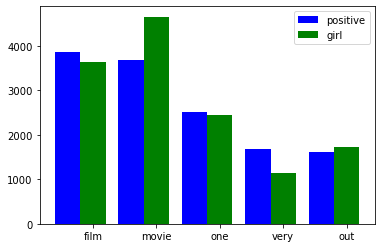

In [628]:
x =list(range(5))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, df5.head(5)['positive'], width=width, label='positive',color = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, df5.head(5)['negative'], width=width, label='girl',tick_label = df5.head(5).index,color = 'g')
plt.legend()
plt.show()

This plot shows the frequency of "film", "movie", "one", "very", "out" in "positive" and "negative". As can be seen from the plot, the five most frequently occurring words in positive reviews also appear a lot in negative reviews.

## Analyze examples of texts which have been misclassified

In [691]:
false_df = test_df.loc[predict_list != test_df['sentiment']]
# Collect false predicted rows.

I calculated the predicted probabilities in the false predicted rows through the function classify and added them to a new DataFrame.

In [724]:
Tp = []
Tn = []
analytsis = false_df.reset_index()
for i in range(0,len(false_df)):
    txt1 = false_df.iloc[i]['review']
    Tp.append(classify(txt1).sum()['log(P(pos|text))'])
    Tn.append(classify(txt1).sum()['log(P(neg|text))'])

analytsis['log(P(pos|text))'] = pd.DataFrame(Tp)
analytsis['log(P(neg|text))'] = pd.DataFrame(Tn)

In [725]:
analytsis['log_Probility_error'] = analytsis['log(P(pos|text))'] - analytsis['log(P(neg|text))']
# Storing the error of log(probility) in analytsis['log_Probility_error']


In [726]:
analytsis

,index,review,sentiment,log(P(pos|text)),log(P(neg|text)),log_Probility_error
0,21492,I saw this recent Woody Allen film because I'm...,negative,-382.490069,-385.056348,2.566279
1,12604,You know? Our spirit is based on that revoluti...,positive,-147.503376,-147.094281,-0.409095
2,17193,"This U.S soap opera, 'Knots Landing' has all t...",negative,-253.363938,-254.473988,1.110050
3,24056,Rich ditzy Joan Winfield (a woefully miscast B...,negative,-433.638252,-435.754354,2.116102
4,10641,So i consider myself pretty big into the anime...,positive,-211.822531,-211.693207,-0.129323
...,...,...,...,...,...,...
3185,2636,"Sure, it was cheesy and nonsensical and at tim...",positive,-203.812479,-203.574805,-0.237674
3186,10665,Dull haunted house thriller finds an American ...,negative,-491.591483,-492.848655,1.257173
3187,16834,The first installment of this notorious horror...,positive,-225.706614,-224.767469,-0.939145
3188,11465,One of the lamer wedding movies you'll see. Sm...,negative,-175.486197,-175.879419,0.393222


In [684]:
np.abs(analytsis['log_Probility_error']).describe()

count    3190.000000
mean        2.164316
std         2.286472
min         0.001339
25%         0.642621
50%         1.425189
75%         2.914307
max        21.240403
Name: log_Probility_error, dtype: float64

There are 3190 false predictions, the average error of the data is about 2.164316, the standard deviation of the error is about 2.286472 and the maximum error is 21.240403. In these cases, the predicted probabilities are very far apart.

### Classify some text samples on your own

For this part I found some audience reviews for *AVENGERS: ENDGAME* from *Rotten Tomatoes*. I use the functions classify and predict to classify these movie reviews.

Audience1(4/5 stars) -- *Kevin M. W* 

Audience2(1/4 stars) -- *Ernesto Diezmartinez*

Audience3(C+) -- *Frank Swietek*

Audience4(4.5/5 stars) -- *Michael M*

Audience5(4/5 stars) -- *Ranjay R* 

In [745]:
Audience1 = "The conclusion of this epic storyline is meant to be, err, epic, and in many ways it succeeds. Marvel throws a proverbial feast for it's legions of fandom for sticking through 10 years and many divergent stories, and many different heroes. Of course, they cannot do justice to everyone and so many get simply a nod or a wave, but the overall effect is still worthy - for first viewing and how ever many viewings that will come after. That the story's problem is tackled with a cliche cinematic solve...well, for entertainment's sake, and seen through the verve given execution, it's a forgivable decision."
Audience2 = "Frigga has one of the funniest lines in the whole movie: 'Son,eat more vegetables.' Indeed, it is not terrible eat junk food from time to time, but we must eat healthier. The same goes for cinema. Endgame is junk food. The healthier cinema is elsewhere."
Audience3 = "Predictable and...overstuffed with snarky lines and bathetic moments, though as sumptuously made as anything to have rolled off the Marvel assembly line [but] since it gives series fans a heaping helping of what they obviously savor, they'll eat it up."
Audience4 = "As a conclusion to over a decades worth of storytelling, it's got a lot to live up to, and it's about as good as you could really hope for it to be. Overall, I really do like Infinity War better. At the end of the day, Infinity War was just a wildly new experience, it was such a gamechanger and crowd-pleaser. Not only that, Infinity War I think had a better final battle. This final battle, while boasting the biggest ensemble of Marvel heroes we've ever seen on screen, is weirdly dark and muddied in CGI scenery compared to the battle at Wakanda from Infinity War. Also I hate Professor Hulk, he's just not that fun. Okay so those are my criticisms, what did I like about the movie? I guess everything else? The time travel plot let's us revisit and honor some old moments in Marvel with a new lens in sort of a Back to the Future Part 2 way that's a lot of fun, and it brings back some characters I didn't think we'd ever see again. The movie has a big emotional core, and a climactic end that is godamn powerful. This movie juggles a lot. Seriously this is like watching someone juggle 10 flaming chainsaws, it's a godamn miracle it works at all. That it works this well is even more of a miracle. It's an imperfect movie, but perfectly satisfying conclusion to this arc of the Marvel saga."
Audience5 = "There isn't too much in the way of suspense or surprises when it comes to the story, but there are some shocking moments and funny lines in this epic finale. Again, like many of the best Marvel films, the holes and flaws are covered up with humor and fan service, making everything okay. That being said, I did prefer Infinity War to this film, which really misses the leads of the other Marvel franchises that were 'snapped' out. Overall, however, there are only a few ways you can wrap up the main story of the MCU, and this was a solid direction."

predict_list = []

A1 = classify(Audience1).sum()
P1 = predict(A1)
A2 = classify(Audience2).sum()
P2 = predict(A2)
A3 = classify(Audience3).sum()
P3 = predict(A3)
A4 = classify(Audience4).sum()
P4 = predict(A4)
A5 = classify(Audience5).sum()
P5 = predict(A5)
predict_list

['negative', 'negative', 'negative', 'positive', 'positive']

Most predictions are accurate, the first prediction is wrong.

# Conclusion

The purpose of this report is to examine the ability of a Naive Bayes classifier to predict whether a movie review is positive or negative based on the review text. Also, check how Naive Bayes predicts which newsgroup a post is submitted to based on the text of the post. My main focus is to make predictions by naive Bayes classifier by the frequency of words and then check the accuracy of the predictions. According to my experimental results: using the Naive Bayes classifier to predict whether a movie review is positive or negative is 54.05% accurate, and using the text of the post to predict which newsgroup a post is submitted to is 23.17% accurate. The five words that appeared most frequently in positive reviews also appeared a lot in negative reviews. And in the case of a wrong prediction, we can see that the predicted probabilities are far apart, with a mean (log(P)) error of 2.164316.